# Determining ice sheet change using Greenland Ice Mapping Project (GrIMP) tools
---

## GrIMP Overview and Tutorial Goals

![GrIMP header](./images/GrIMP_header.png)

```{note} Learning Objectives
	
1. Access GrIMP velocity products, formatted as cloud optimized GeoTIFF
2. Explore product header info and structure
3. Use interactive subsetting and save tools
4. Use lazy loads to quickly plot imagery and velocity
5. Combine raster and vector data to quickly assess glacier speed and terminus change 
```

This notebook illustrates some of the various tools and capabilities available to access and explore imagery and velocity data products from the Greenland Ice Mapping Project [GrIMP](https://nsidc.org/grimp). Specifically, we will use the functionality of `nisarVel` and `nisarVelSeries` classes for working with GrIMP velocity products.

This notebook will also include examples of how to quickly explore imagery and velocity mosaics, formatted as cloud optimized GeoTIFF (more on that below) to interactively select and download subsets of GrIMP imagery (NSIDC-0723) and velocity (NSIDC-481, 0725, 0727, 0731, 0766) data. For the Sentinel-based velocity mosaics (0725, 0727, 0731), a user can select a box on a map and choose which components are downloaded (vv, vx, vy, ex, ey, dT) and saved to a netCDF file. 

We will explore some of this functionality, read in and plot velocities over an area of interest, quickly run some statistical calculations to visualize how ice flow has changed. We will also combine data with vector data (digitized annual front positions, product 0642), to assess glacier speed and terminus change in tangent.

## Environment setup

Generally, GrIMP notebooks use a set of tools that have been tested with the `environment.yml` in the *binder* folder of the [**GrIMP repository**](https://github.com/fastice/GrIMPTools). Thus, for best results when using GrIMP notebooks in the future and in local instances, create a new conda environment to run this and other other GrIMP notebooks from this repository. After downloading the `environment.yml` file, enter the following commands at the command line to prepare your environment. For today's tutorial in CryoCloud, we do not need to perform these steps.

`conda env create -f binder/environment.yml`

`conda activate greenlandMapping`

`python -m ipykernel install --user --name=greenlandMapping`

`jupyter lab`

See [NSIDCLoginNotebook](https://github.com/fastice/GrIMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for additional information.

The notebooks can be run on a temporary virtual instance (to start click [**binder**](https://mybinder.org/v2/gh/fastice/GrIMPNotebooks/HEAD?urlpath=lab)). See the github [README](https://github.com/fastice/GrIMPNotebooks#readme) for further details.

### Specialty GrIMP product imports

```{note}
In order to use the full functionality of GrIMP notebooks for this tutorial, we will pip install two
two packages with funcitons for reading, subsetting, plotting, and downloading various datasets.
```

In [1]:
%pip install git+https://github.com/fastice/grimpfunc.git@master
%pip install git+https://github.com/fastice/nisardev.git@main

  Cloning https://github.com/fastice/grimpfunc.git (to revision master) to /tmp/pip-req-build-c45rfktj
  Running command git clone --filter=blob:none --quiet https://github.com/fastice/grimpfunc.git /tmp/pip-req-build-c45rfktj
  Resolved https://github.com/fastice/grimpfunc.git to commit 4b28af37b4a56b18bdbf97baf86f6d132977240d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached stackstac-0.5.0-py3-none-any.whl (63 kB)
  Using cached progressbar2-3.55.0-py2.py3-none-any.whl (26 kB)
  Using cached panel-0.14.4-py2.py3-none-any.whl (20.8 MB)
  Using cached rio_stac-0.8.1-py3-none-any.whl (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.7 MB/s eta 0:00:0000:0100:01
  Using cached holoviews-1.17.1-py2.py3-none-any.whl (4.3 MB)
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)
  Using cached python_utils-3.8.1-py2.py3-none-any.whl (27 kB)
  Created wheel for grimpfunc: fi

### Common package imports

In [2]:
import ipywidgets

#import IS2view
#import icepyx as ipx
import h5py

# Ignore warnings for tutorial
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import geopandas as gpd
import json
import pyproj
import numpy as np
import earthaccess
import glob
import os
import sys
import re
import matplotlib.pyplot as plt
from IPython.display import Image
import rasterio
from rasterio import plot

import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)
import nisardev as nisar
import matplotlib.colors as mcolors
import grimpfunc as grimp
import panel
panel.extension()
from datetime import datetime
import xarray as xr
from shapely.geometry import box, Polygon
os.environ['USE_PYGEOS'] = '0'

import rioxarray

from IPython.lib.deepreload import reload


%load_ext autoreload
%autoreload 2

In [3]:
# For searching NASA data
auth = earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 11/21/2023
Using .netrc file for EDL




### &#x1F4CC; More tutorial guidance:
See our [YouTube](https://www.youtube.com/@GreenlandIceMappingProject) page for more:

In [4]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/0kIcSXkxaxI" \
     frameborder="0" allow="accelerometer" allowfullscreen></iframe>')

```{note}
**To get help and see options for any of the GrIMP or other functions while the cursor is \
positioned inside a method's parentheses, click shift+Tab.**
```

## Overview of COGs and GrIMP product exploratory tool

GrIMP velocity products are stored at NSIDC in cloud-optimized GeoTIFF (COG) format with each component stored as a separate band (e.g., vx, vy, or vv). In this notebook, we focus on the velocity data, but the error and x and y displacement components can be similarly processed.

For reading the data, the products are specified with a single root file name (e.g., for `*filename.vx(vy).othertext.tif*`). For example, the version 3 annual mosaic from December 2017 to November 2018 is specified as `GL_vel_mosaic_Annual_01Dec17_30Nov18_*_v03.0`. For locally stored files, the corresponding path to the data must be provided. For remote data, the https link is required. 

In [4]:
myUrls = grimp.cmrUrls(mode='subsetter')  # Subsetter mode is required for subsetting.
display(myUrls.initialSearch())

Row
    [0] Column(min_width=700)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=700)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method, _pane=DataFrame)
        [1] ParamMethod(method, _pane=Markdown)
        [2] ParamMethod(method, _pane=Markdown)

This cell will pop up a search tool for the GrIMP products, which will run a predefined search for the annual products. While in principle, other products (e.g., six-day to quarterly can be retrieved, the rest of the notebook will need some modifications to accomodate).

### Preload Data and Select Bands
The cells in this section read the cloud-optimized geotiffs (COG) headers and create nisarVelSeries or nisarImageSeries objects for velocity or image data, respectively. The actual data are not downloaded at this stage, but the xarray internal to each object will read the header data of each product so it can efficiently access the data during later downloads. The bands (e.g., vx, vy) can be selected at this stage.

More detail can found on working with these tools in the workingWithGrIMPVelocityData and workingWithGrIMPImageData notebooks. 

```{note}
The  nisar class is used to read, display, velocity maps with a single time stamp. In this example, the `readSpeed=False` (default) forces the speed to be calculated from the individual components rather than read from a file, which is much quicker.

: Here is an example of how to access header information remotely and see the structure and total size of your potential download

:     myVelSeries = nisar.nisarVelSeries() 
      myVelSeries.readSeriesFromTiff(myUrls.getCogs(replace='vv', removeTiff=True), url=True, readSpeed=False, useErrors=True, useDT=True)  
      myVelSeries.xr
```

### View example mosaic product from local file
For the purpose of this tutorial, we will read in a file saved locally to the shared directory to visualize an example of the annual velocity mosaic

In [6]:
myVelSeries = nisar.nisarVelSeries() # Initialize a nisarVelSeries instance:
localUrl = '/home/jovyan/shared-public/GeoTIFF/GL_vel_mosaic_Annual_01Dec20_30Nov21_*_v04.0'
myVelSeries.readSeriesFromTiff([localUrl], useDT=False,useErrors=False,readSpeed=True,url=False,useStack=True,overviewLevel=1)  
myVelSeries.xr

<xarray.DataArray 'VelocitySeries' (time: 1, band: 3, y: 3425, x: 1896)>
dask.array<concatenate, shape=(1, 3, 3425, 1896), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U2 'vx' 'vy' 'vv'
  * x            (x) float64 -6.587e+05 -6.579e+05 ... 8.567e+05 8.575e+05
  * y            (y) float64 -6.395e+05 -6.403e+05 ... -3.378e+06 -3.379e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2021-06-01
    name         <U4 'None'
    _FillValue   (band) float64 -2e+09 -2e+09 -1.0
    time1        datetime64[ns] 2020-12-01
    time2        datetime64[ns] 2021-11-30

#### Plot velocity map

 We can use the: 
 ```
     myVelSeries = nisar.nisarVelSeries.displayVelForDate()
```
function to plot the velocity map for the annual mosaic nearest the user-provided date   &#x2B07;. 

[########################################] | 100% Completed | 342.77 ms
[########################################] | 100% Completed | 101.21 ms


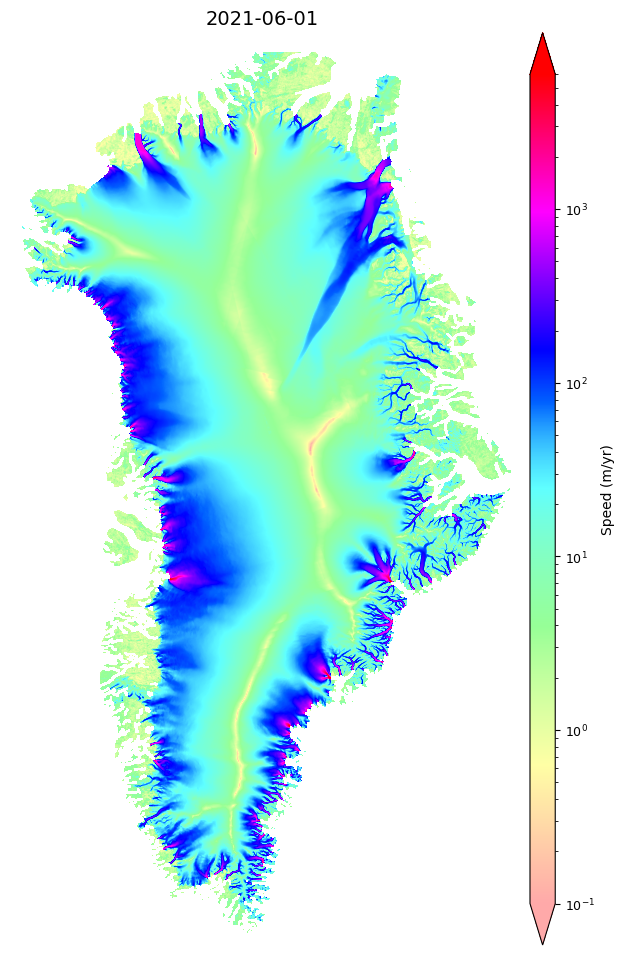

In [7]:
myVelSeries.displayVelForDate('2021-06-01',labelFontSize=10, plotFontSize=9, titleFontSize=14, 
                              vmin=0, vmax=6000,scale='log',colorBarPad=0.15,units='km', axisOff=True)

## &#128208; Spatial subsetting routines 
&#x1F6A8;**These files can be large!**

Below are functions that allow you to quickly *subset the data by spatial bounds*, including the functions you can use to interactively select an ROI when exploring datasets remotely

### Method 1: Interactive ROI Selection
Run the next the tool below to select the bounding box (or modify a manually selected box), which will display a SAR image map. Depending on network speed, it could take a few seconds to a minute to load the basemap. Use the box tool in the plot menu to select a region of interest. 

```{admonition} Interactive ROI selection
:
:     if 'boxPicker' not in locals(): # Only create if not defined above
          boxPicker = grimp.boxPicker()
      boxPicker.plotMap(show=(not myUrls.checkIDs(['NSIDC-0481']) and not myUrls.checkIDs(['NSIDC-0646'])))
```

### Method 2: Manual Selection
The coordinates for bounding box, bbox, can be manually entered by modifying the cell below with the desired values. Even if not using interactive selection, running that step displays the manually selected box coordinates on a radar map of Greenland. Note by default, coordinates are rounded to the nearest kilometer. We will use a predefined `bbox` for the tutorial today.

In [8]:
values = np.around([-472889, -2540695, -453487, -2523127])
xyBounds = dict(zip(['minx', 'miny', 'maxx', 'maxy'], values))
xyBounds

myVelSeries.subSetVel(xyBounds)
myVelSeries.subset

<xarray.DataArray 'VelocitySeries' (time: 1, band: 3, y: 22, x: 25)>
dask.array<getitem, shape=(1, 3, 22, 25), dtype=float32, chunksize=(1, 1, 22, 25), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U2 'vx' 'vy' 'vv'
  * x            (x) float64 -4.731e+05 -4.723e+05 ... -4.547e+05 -4.539e+05
  * y            (y) float64 -2.524e+06 -2.524e+06 ... -2.54e+06 -2.54e+06
  * time         (time) datetime64[ns] 2021-06-01
    name         <U4 'None'
    _FillValue   (band) float64 -2e+09 -2e+09 -1.0
    time1        datetime64[ns] 2020-12-01
    time2        datetime64[ns] 2021-11-30
    spatial_ref  int64 0

The data in the above example map are stored as an Xarray, velMap.subset. In this case, the subset is the full map of Greenland for one time slice. The full time series of Greenland-wide mosiacs can reach sizes of > 8GB and may take awhile to download! Because of the lazy open mentioned above, the data have not been downloaded or read from the disk yet. Before applying the final subset, its useful to examine the size of the full data (virtual) array. If the loadDataArray step was sucessful, this next cell will provide details on the size and organization of the full xarray (prior to any download).

```{admonition} Optionally download subset as netcdf file
The downloaded subset can be saved in a netcdf and reloaded for to velSeries instance for later   analysis.   Note if the data have been subsetted, ONLY the subset will be saved - so it is not a bad idea to check out the dimensions, variable names, and total size of the subset data one last time prior to downloading.

: Add comment on xy bounds           
:     myVelSeries.subSetVel(xyBounds)
      myVelSeries.subset

: Add comment on export to cdf
:     subsetFile = 'steenstrupGlacier_annVel.nc'
      myVelSeries.loadRemote()
      myVelSeries.toNetCDF(subsetFile)
      
```


### Use predownloaded subset for plotting

In [5]:
# Now reload the downloaded data
myVelReload = nisar.nisarVelSeries() 
myVelReload.readSeriesFromNetCDF('./res/steenstrupGlacier_annVel.nc')
myVelReload.loadRemote()

In [12]:
myVelReload.xr #confirm dimensions of read-in subsetted velocities
vv = myVelReload.subset[:,2,:,:]
print(min(vv.x))

<xarray.DataArray 'x' ()>
array(419000.)
Coordinates:
    _FillValue   float64 -1.0
    band         <U2 'vv'
    x            float64 4.19e+05
    epsg         int64 3413
    name         <U4 'temp'
    spatial_ref  int64 0
Attributes:
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate
    units:          metre


In [9]:
poly = Polygon([(min(vv.x), min(vv.y)), (min(vv.x),max(vv.y)), (max(vv.x), max(vv.x)), (max(vv.x),min(vv.y))])
clippoly = gpd.GeoDataFrame([1], geometry = [poly], crs = crs)
clippedfronts = gpd.clip(gdf,clippoly)

TypeError: 'nisarVelSeries' object is not subscriptable

## &#128205; Combine GrIMP raster and vector data
Let's read in digitized annual terminus traces within this ROI. 

In [13]:
#folder = Path("/home/jovyan/GrIMP/shpfiles")
#shapefiles = folder.glob("*.shp")
#gdf = pandas.concat([
#   gpd.read_file(str(shp))
#   for shp in shapefiles
#]).pipe(gpd.GeoDataFrame)
#gdf.to_file(folder / 'compiled.shp')
fronts = gpd.read_file("/home/jovyan/GrIMP/shpfiles/compiled.shp")

In [19]:
crs = fronts.crs
poly = Polygon([(min(vv.x), min(vv.y)), (min(vv.x),max(vv.y)), (max(vv.x), max(vv.x)), (max(vv.x),min(vv.y))])
clippoly = gpd.GeoDataFrame([1], geometry = [poly], crs = crs)
clippedfronts = gpd.clip(fronts,clippoly)
print(clippedfronts.head())

Empty GeoDataFrame
Columns: [Image_ID, Sensor, Glacier_ID, SourceDate, Quality_Fl, geometry]
Index: []


<Axes: title={'center': '_FillValue = -1.0, time = 2015-06-01, id = http...'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

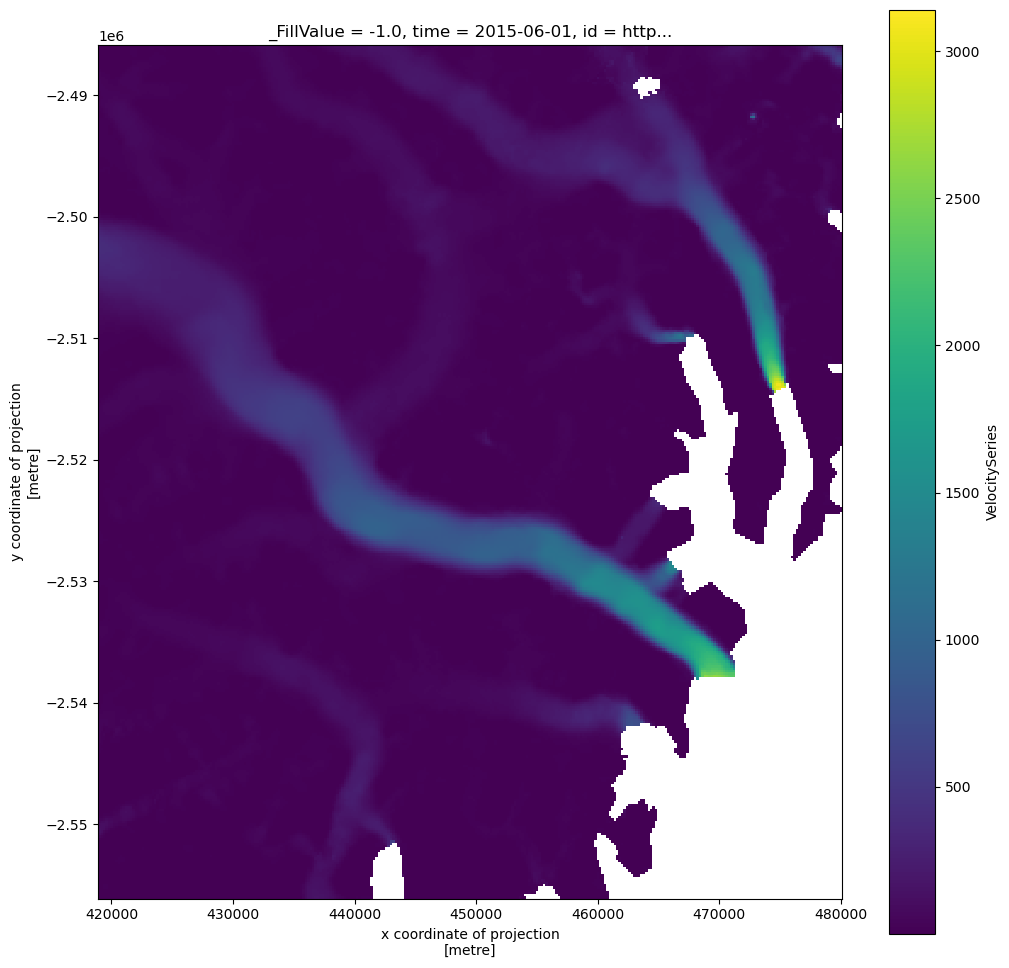

In [18]:
f, ax = plt.subplots(1,1,figsize=(12, 12))
sm = vv[0,:,:]
sm.plot(ax = ax, cmap='viridis')
clippedfronts.plot(column='SourceDate', cmap=None, ax=ax,legend=True)

AttributeError: 'DataArray' object has no attribute 'view'

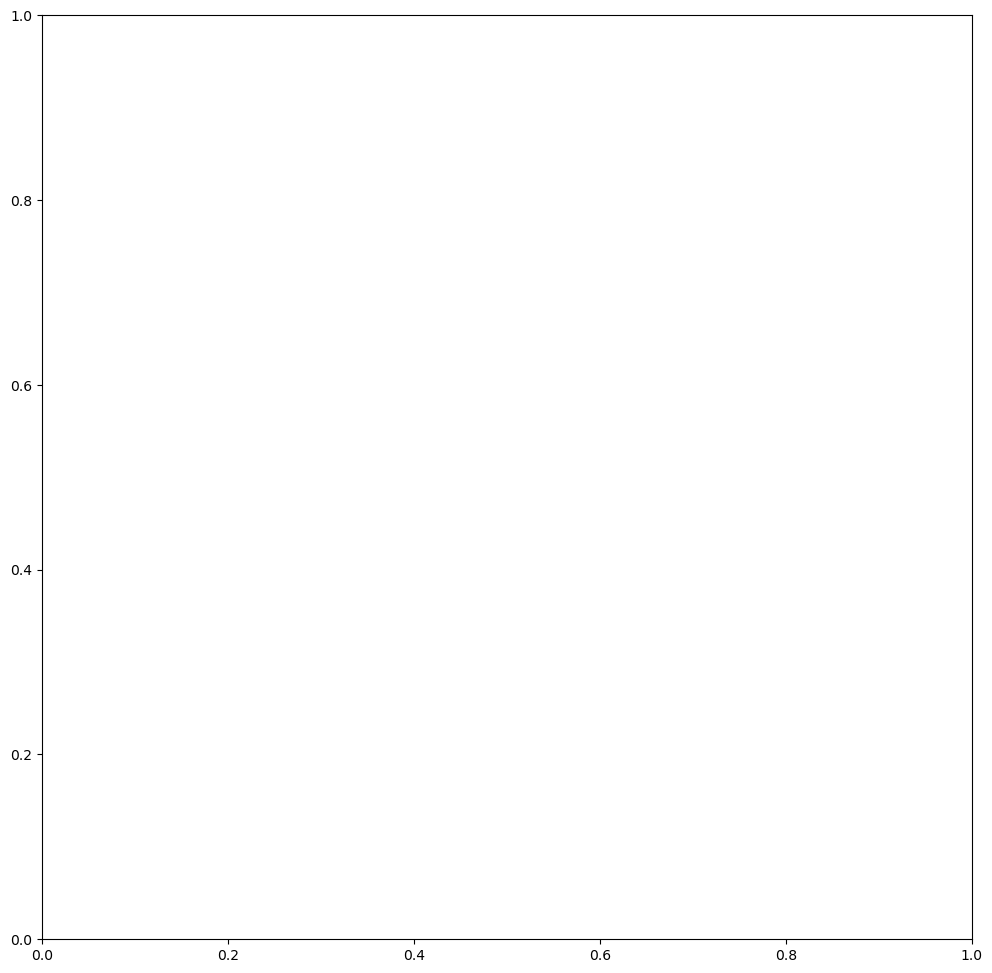

In [16]:
r2 = rasterio.plot.show(sm,ax=ax,cmap='viridis',alpha=0.6)
clippedfronts.plot(column='SourceDate', cmap=None, ax=ax,legend=True)

In [13]:
for i in range(1, 3):
    myShapeFiles += glob.glob(f'shpfiles/*.shp')#shpfiles/glacier?00{i}.shp')  # Search for glaciers with ?00n where n ranges from 1 to 6
# Build dictionary with flowlines indexed by glacier id
myFronts = {x[-8:-4]: grimp.Flowlines(shapefile=x, name=x[-8:-4], length=50e3) for x in myShapeFiles} 
myFlowlines

KeyError: 'flowline'

### &#128397; Plot the annual velocity maps for Steenstrup Glacier. 

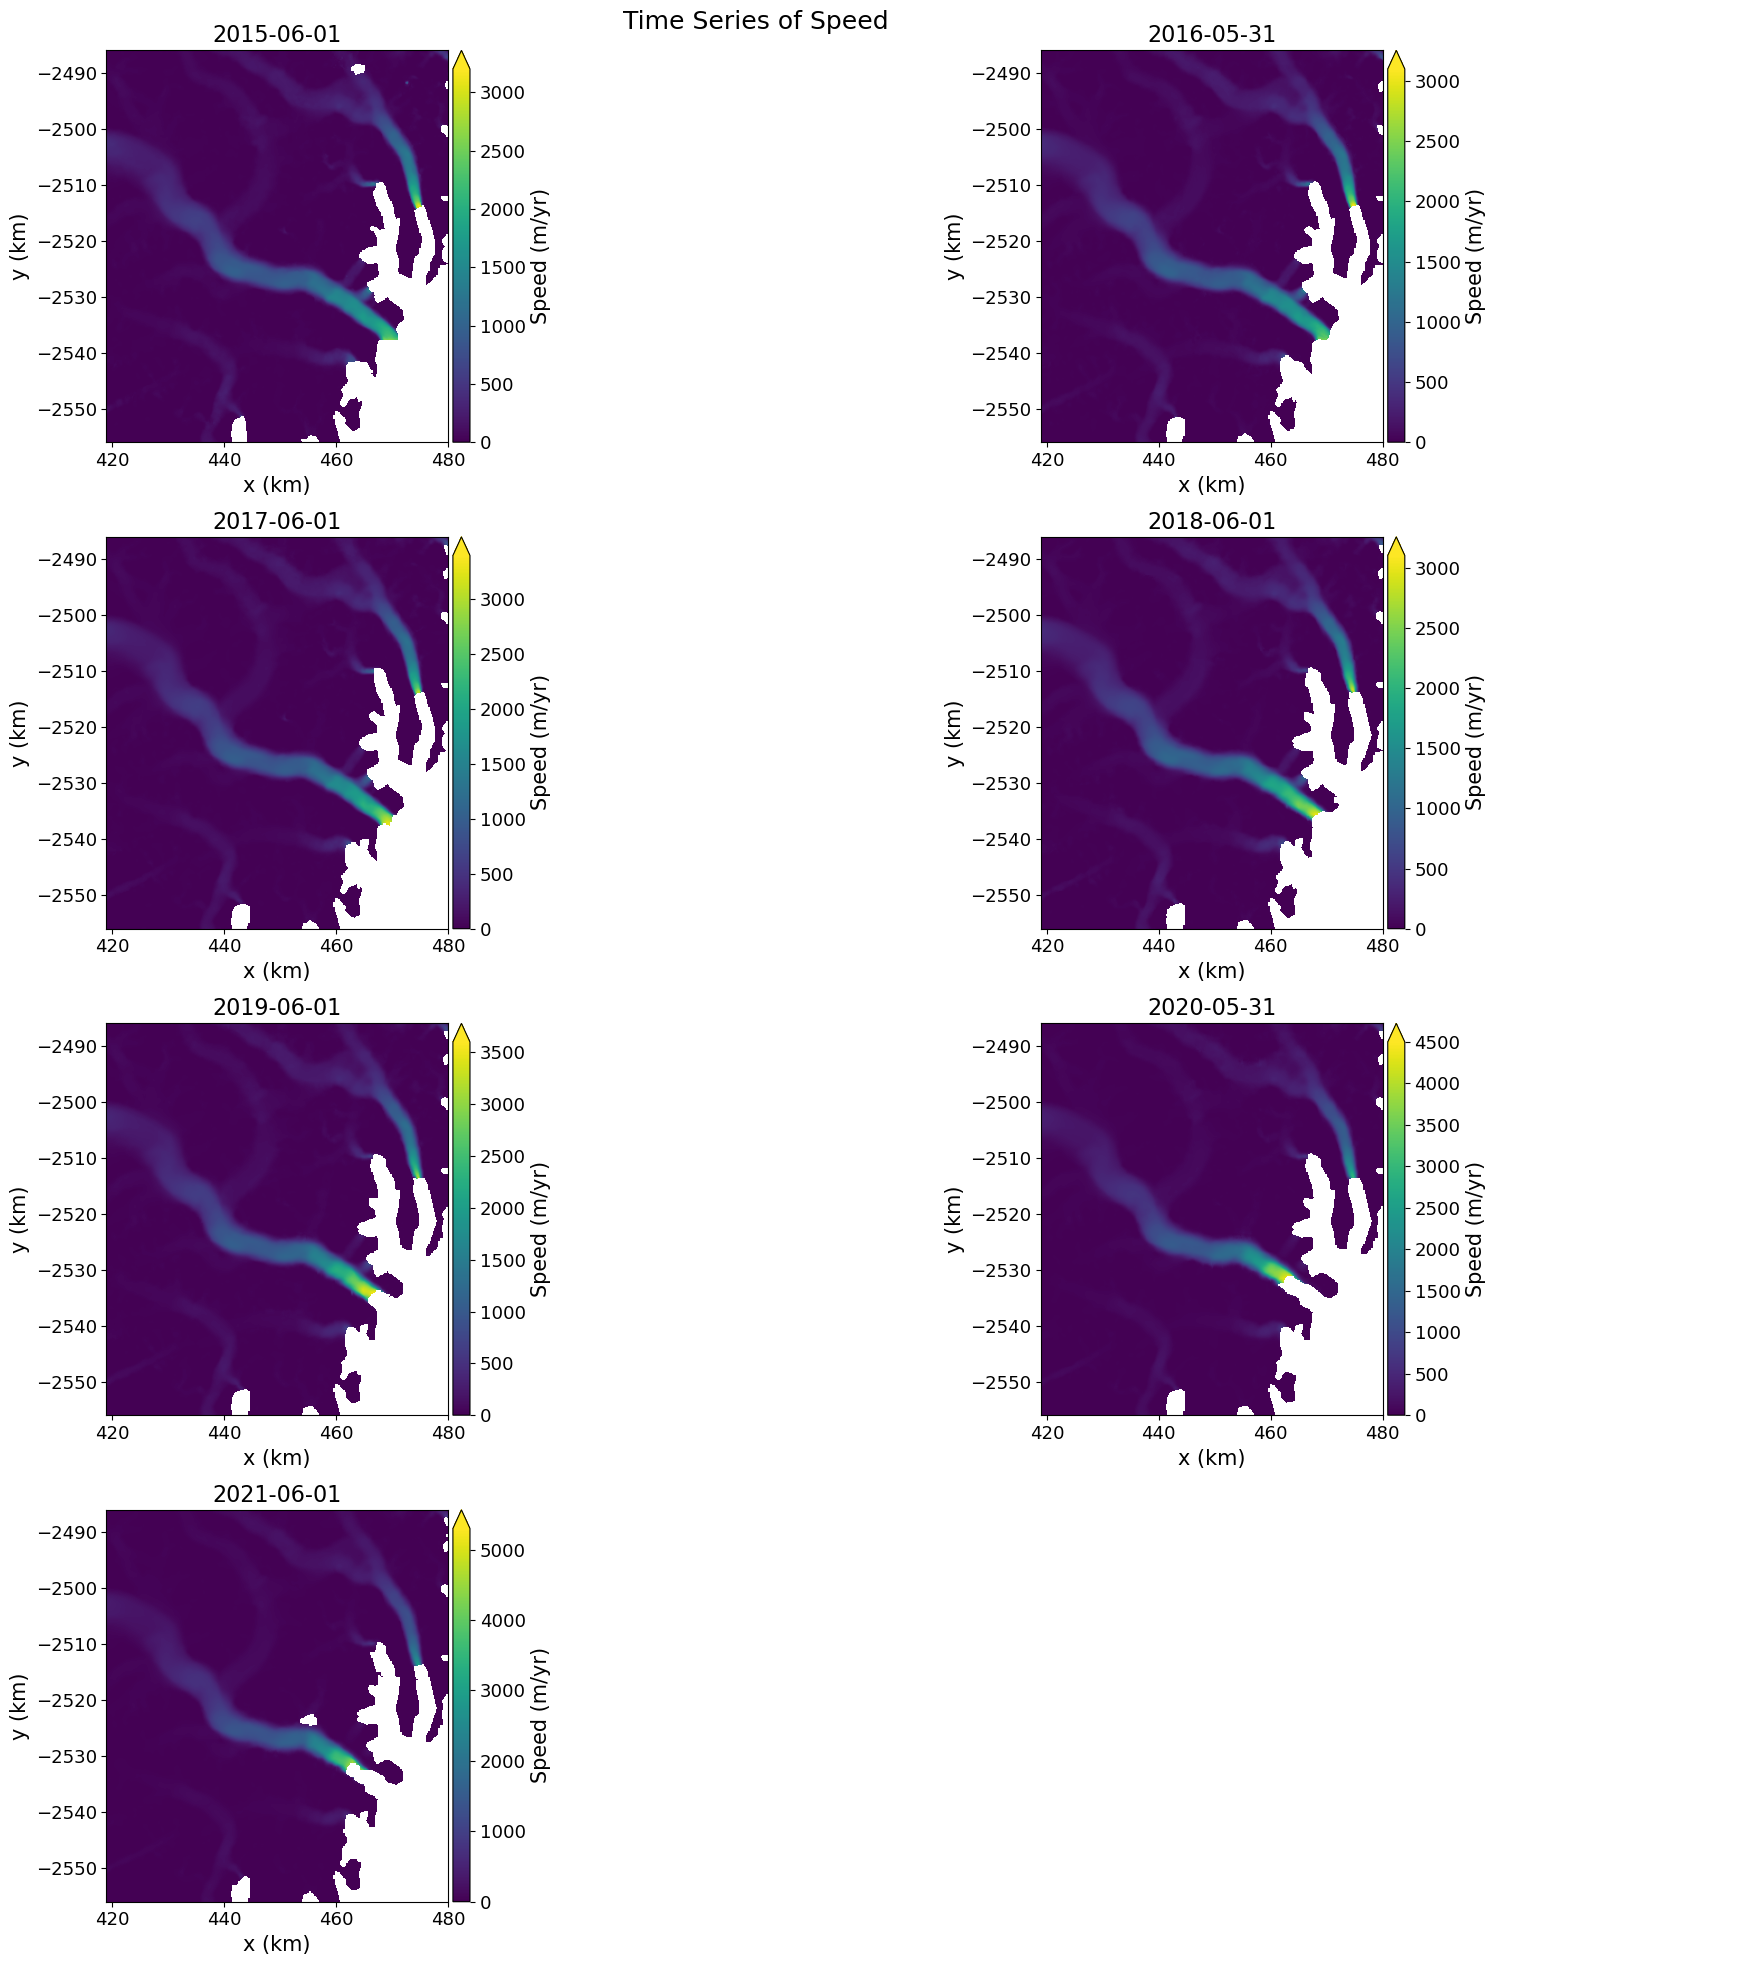

In [11]:
fig, axes = plt.subplots(4, 2,figsize=(20,20))

for ax, date in zip(axes.flatten(), myVelReload.time): 
    myVelReload.displayVelForDate(date=date, ax=ax,units='km')
axes[-1, -1].axis('off'); #remove any empty axes if odd number of years
fig.suptitle('Time Series of Speed', fontsize=18)
fig.tight_layout()

from shapely.geometry import box, Polygon
poly = Polygon([(min(melvel.x), min(melvel.y)), (min(melvel.x),max(melvel.y)), (max(melvel.x), max(melvel.x)), (max(melvel.x),min(melvel.x))])
clippoly = gpd.GeoDataFrame([1], geometry = [poly], crs = crs)
clippedfronts = gpd.clip(gdf,clippoly)
print(clippedfronts)

#ax.set_aspect('equal')
#bwim[timeS,0,:,:].plot(ax=ax,cmap='gray',zorder = 1)
#gdf.plot(ax = ax, color = 'r',zorder = 3)
#maskXform.plot(ax=ax,edgecolor = 'w',facecolor='none',zorder=4)

### &#x1F4C8; Explore multiyear trends with Quick tool
Use the interactive inspection tool in the cell block below to quickly visualize multiyear trends &#x2B07;


In [12]:
myVelReload.inspect()

HoloViews(Layout)

### &#x1F4CA; Quickly plot velocity anomalies
computes [velocity at t_i - mean] of all timesteps in data series

In [ ]:
velAnomaly = myVelReload.anomaly()

# Plot the anomaly for each year
fig, axes = plt.subplots(2, 4, figsize=(20,10))
for date, ax in zip(velAnomaly.time, axes.flatten()):
    velAnomaly.displayVelForDate(date, ax=ax, units='m', vmin=-600, vmax=600, autoScale=False, axisOff=True,
                                 title=date.strftime("%Y"),cmap='RdBu_r', colorBarLabel='Speed Anomaly (m/yr)', 
                                 extend='both',backgroundColor=(0.6, 0.6, 0.6))
axes[-1, -1].axis('off'); # kill axis with no plot
fig.suptitle('Speed Anomalies by Year', fontsize=16)
fig.tight_layout()

### &#127909; Create animation of Annual Velocities and terminus change

In [ ]:
from matplotlib import animation
from IPython.display import HTML

In [ ]:
gdf = gpd.read_file('/Volumes/insar10/ian/Sentinel1/Release/termini/v2.0/termini_2020_2021/termini_2020_2021.shp')
print (gdf)
crs = gdf.crs

In [ ]:
fig, ax = plt.figure(figsize=(16,8)) 
#cogs = annualVel
#term = AnnualTrace

def drawframe(theta):
    sm = rasterio.open(cogs[theta])
    sm3 = rxr.open_rasterio(cogs[theta],masked=True)
    sm4 = rxr.open_rasterio(cogs2[theta],masked=False)
    melONLY = sm3 - sm4 ;
    maskeddata = np.ma.masked_where(melONLY <= 0,melONLY)
    r1 = rasterio.plot.show(bw,ax=ax1,cmap='gray')
    r2 = rasterio.plot.show(sm,ax=ax1,cmap='viridis',alpha=0.6)
    r3 = rasterio.plot.show(bw,ax=ax2,cmap='gray')
    #show((sm2, 1), ax=ax2, transform=sm.transform,cmap='viridis', title='green channel')
    im = show(maskeddata, ax=ax2, transform=sm.transform,cmap='viridis', vmin = 10,vmax = 10000,alpha = 0.6,title='Rigid Melange')
    return r1,r2,r3,im

ani = animation.FuncAnimation(fig, drawframe, frames=20, 
                              interval=300)
HTML(ani.to_html5_video())

## Dynamic Thinning at ice sheet margins
Typically, we expect a rapid acceleration in ice flow to also correspond with dynamic ice thinning. Let's use ICESat-2 data to see if that is true for Steenstrup Glacier.

![glacier thinning](./images/dynamic_thinning_schematic.png)

```{admonition} Accessing from the cloud (outside of tutorial)
Follow the example block of code below to access non-local data outside of tutorial  

: Give ROI, product, and temporal range to query using icepyx
:     spatial_extent = [-34.8799,66.4665,-34.3847,66.6506]
      region_a = ipx.Query('ATL06',spatial_extent,['2019-01-01','2021-12-31'])
      region_a.earthdata_login()
      
: Explore variables, select those of interest and download submitted granule order.
:     region_a.show_custom_options(dictview=True)
      region_a.order_vars.avail(options=True)
      region_a.visualize_spatial_extent()
      region_a.download_granules('/home/jovyan/icesat2data') #download path (replace with preferred directory)
```

## Use Ben Smith's function to read in ATL06 (ICESat-2 land ice product) data from local files

In [14]:
def atl06_to_dict(filename, beam, field_dict=None, index=None, epsg=None):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            beam: a string specifying which beam is to be read (ex: gt1l, gt1r, gt2l, etc)
            field_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
            index: which entries in each field to read
            epsg: an EPSG code specifying a projection (see www.epsg.org).  Good choices are:
                for Greenland, 3413 (polar stereographic projection, with Greenland along the Y axis)
                for Antarctica, 3031 (polar stereographic projection, centered on the Pouth Pole)
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a numpy array containing the 
                data
    """
    if field_dict is None:
        field_dict={None:['latitude','longitude','h_li', 'atl06_quality_summary'],\
                    'ground_track':['x_atc','y_atc'],\
                    'fit_statistics':['dh_fit_dx', 'dh_fit_dy']}
    D={}
    file_re=re.compile('ATL06_(?P<date>\d+)_(?P<rgt>\d\d\d\d)(?P<cycle>\d\d)(?P<region>\d\d)_(?P<release>\d\d\d)_(?P<version>\d\d).h5')
    with h5py.File(filename,'r') as h5f:
        for key in field_dict:
            for ds in field_dict[key]:
                if key is not None:
                    ds_name=beam+'/land_ice_segments/'+key+'/'+ds
                else:
                    ds_name=beam+'/land_ice_segments/'+ds
                if index is not None:
                    D[ds]=np.array(h5f[ds_name][index])
                else:
                    D[ds]=np.array(h5f[ds_name])
                if '_FillValue' in h5f[ds_name].attrs:
                    bad_vals=D[ds]==h5f[ds_name].attrs['_FillValue']
                    D[ds]=D[ds].astype(float)
                    D[ds][bad_vals]=np.NaN
    if epsg is not None:
        xy=np.array(pyproj.proj.Proj(epsg)(D['longitude'], D['latitude']))
        D['x']=xy[0,:].reshape(D['latitude'].shape)
        D['y']=xy[1,:].reshape(D['latitude'].shape)
    temp=file_re.search(filename)
    D['rgt']=int(temp['rgt'])
    D['cycle']=int(temp['cycle'])
    D['beam']=beam
    return D

In [19]:
# Read in local SAR mosaic of our glacier of interest
img_name = '/home/jovyan/shared-public/GeoTIFF/GL_S1bks_mosaic_uncalibrated._2021-08-05.tif'
img = rasterio.open(img_name)

# read in first band of imagery
array = img.read(1)
array[array < 0] = 0

# Read ATL06 land ice elevation from GT2l track
ATL06_file0=('./res/processed_ATL06_20191106230008_06270503_006_01.h5')
D0=atl06_to_dict(ATL06_file0,'/gt2l', index=None, epsg=3413)
ATL06_file1=('./res/processed_ATL06_20211102121853_06271303_006_01.h5')
D1=atl06_to_dict(ATL06_file1,'/gt2l', index=None, epsg=3413)

## Now plot ICESat-2 and velocity change together to evaluate if dynamic thinning occurred

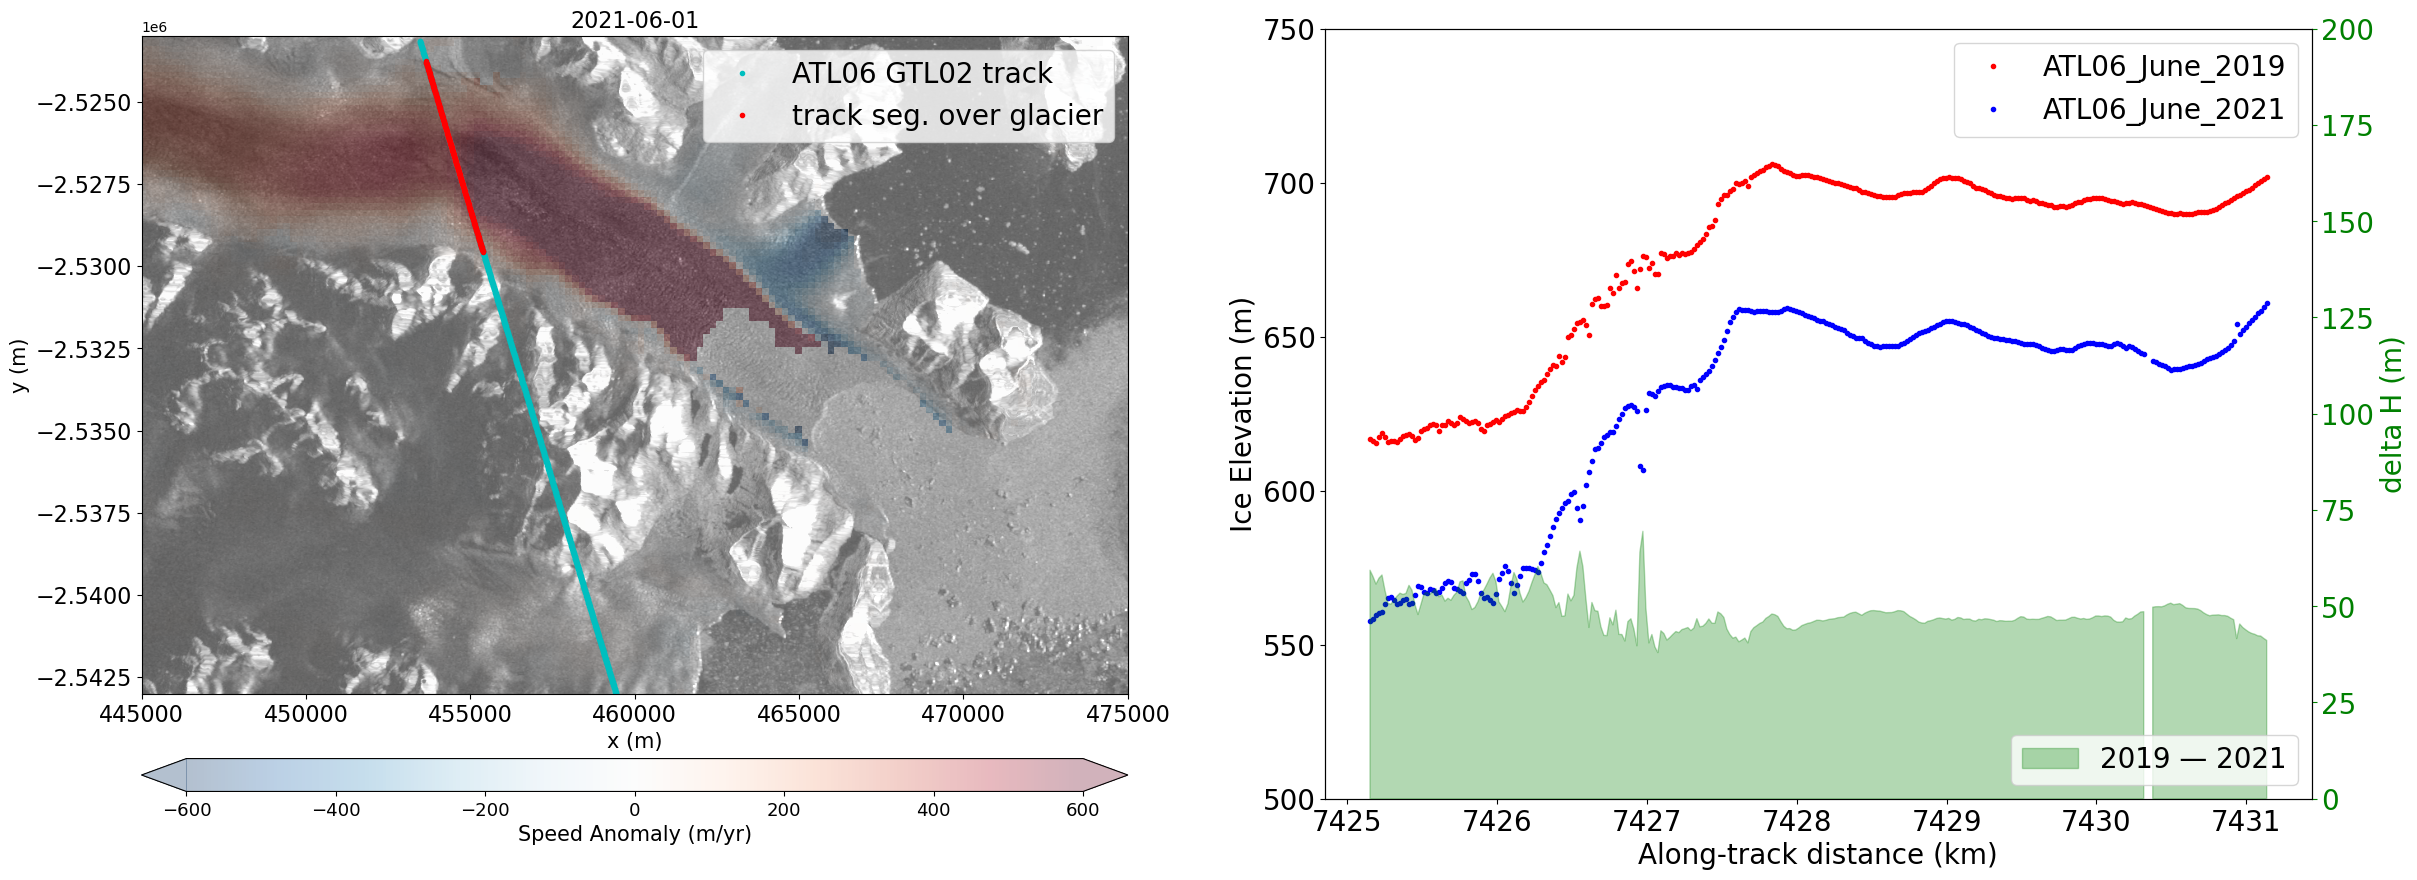

In [20]:
fig = plt.figure(figsize=(28,10))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

#ax1
bounds = np.linspace(-15, 210, 255)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
rasterio.plot.show(array,ax=ax1,cmap='gist_gray',transform=img.transform,norm=norm)
velAnomaly.displayVelForDate('2021-06-01', ax=ax1, units='m', vmin=-600, vmax=600, autoScale=False,colorBarPosition='bottom',
                        colorBarPad=0.65,colorBarSize='5%',cmap='RdBu_r', colorBarLabel='Speed Anomaly (m/yr)', 
                        extend='both',alpha=0.3)

ax1.plot(D1['x'], D1['y'],'c.',label='ATL06 GTL02 track')
ax1.plot(D1['x'][700:1000], D1['y'][700:1000],'r.',label='track seg. over glacier')
ax1.set_xlim(445000,475000)
ax1.set_ylim(-2543000,-2523000)
ax1.legend(fontsize=20);
ax1.tick_params(axis='both', labelsize=16)

#ax2
ax2.plot(0.001*D0['x_atc'][700:1000], D0['h_li'][700:1000],'r.', label='ATL06_June_2019')
ax2.plot(0.001*D1['x_atc'][700:1000], D1['h_li'][700:1000],'b.', label='ATL06_June_2021')
ax2.set_ylim(500,750)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_ylabel('Ice Elevation (m)',fontsize=20)
ax2.set_xlabel('Along-track distance (km)',fontsize=20)
ax2.legend(fontsize=20); 

#calculate 2019 - 2021 difference in elevation
ax_c = ax2.twinx()

deltaH = D0['h_li'][700:1000]- D1['h_li'][700:1000]
deltaH[deltaH > 200] = np.NaN

ax_c.fill_between(0.001*D0['x_atc'][700:1000],deltaH,color='green',alpha=0.3,label='2019 — 2021')
ax_c.set_ylim(0,200)
ax_c.tick_params(axis='y', labelsize=20,labelcolor='green',color='green')
ax_c.set_ylabel('delta H (m)',fontsize=20,color='green');
ax_c.legend(loc='lower right',fontsize=20); 